Just copy and slightly modify the `tensorflow_tensorrt_conversion.ipynb` notebook here and rerun it for this trained model.

In [2]:
import sys
from pathlib import Path
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace

In [3]:
sys.path.append('../../')

In [4]:
from test_fast_inference.tensorflow_tensorrt_conversion import *

# Create model

In [5]:
in_channels  = 1
out_channels = 5
layout_encoder = [[[16,5,2]],
                  [[16,3,1],[16,3,2]],
                  [[16,3,1],[16,3,2]],
                  [[16,3,1],[16,3,2]]]
model = UNET_TRT(get_encoder(in_channels, layout_encoder), out_channels)

In [6]:
model.load_weights('checkpoints/best.tf')

Now, check inference real quick

In [7]:
X = np.fromfile('../../batches/X0.raw', dtype=np.float32).reshape(1, 384, 512, 1)
X = tf.convert_to_tensor(X)

In [8]:
y = model(X)

In [9]:
%%timeit
y = model(X)

18.3 ms ± 333 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [10]:
y[0,0,0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=3.7695749>

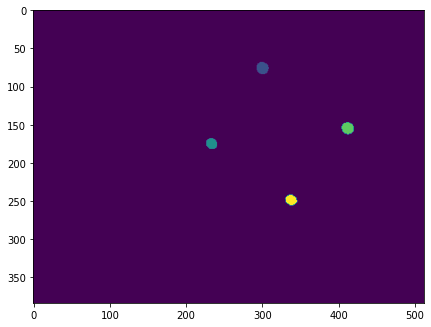

In [11]:
plt.figure(figsize=(7, 7))
plt.imshow(tf.argmax(y, axis=3)[0], vmin=0, vmax=4)

Save model for conversion to tensorrt

In [12]:
model.save('model.tf')

/home/justin/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:2310: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '
/home/justin/miniconda3/envs/tensorflow/lib/python3.7/site-packages/tensorflow/python/keras/engine/base_layer.py:1388: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`layer.updates` will be removed in a future version. '


INFO:tensorflow:Assets written to: model.tf/assets


# Tensorrt with trt_convert (32 bit)

In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.compiler.tensorrt import trt_convert as trt

If memory growth is disabled tensorflow preallocates all GPU RAM and then I eventually run out of memory

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP32,
                                                               max_workspace_size_bytes=2000000000)
converter = trt.TrtGraphConverterV2(input_saved_model_dir='model.tf', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='model_32_trt.tf')

INFO:tensorflow:Linked TensorRT version: (7, 2, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 0)
INFO:tensorflow:Could not find TRTEngineOp_0_4 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_5 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_1 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_2 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_3 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngi

In [5]:
model = tf.saved_model.load('model_32_trt.tf', tags=[tag_constants.SERVING])
model = model.signatures['serving_default']

In [6]:
X = np.fromfile('../../batches/X0.raw', dtype=np.float32).reshape(1, 384, 512, 1)
X = tf.convert_to_tensor(X)

In [7]:
y = model(X)

In [8]:
%%timeit 
y = model(X)

2.18 ms ± 119 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [9]:
y['output_1'][0,0,0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=3.769575>

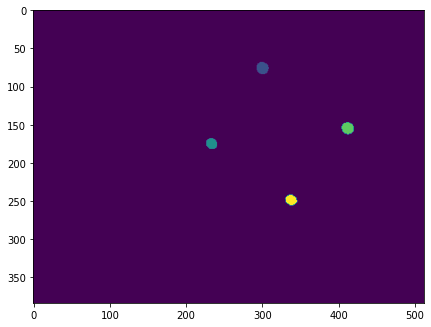

In [10]:
plt.figure(figsize=(7, 7))
plt.imshow(tf.argmax(y['output_1'], axis=3)[0], vmin=0, vmax=4)

# Tensorrt with trt_convert (16 bit)

In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.compiler.tensorrt import trt_convert as trt

If memory growth is disabled tensorflow preallocates all GPU RAM and then I eventually run out of memory

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [4]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.FP16,
                                                               max_workspace_size_bytes=2000000000)
converter = trt.TrtGraphConverterV2(input_saved_model_dir='model.tf', conversion_params=conversion_params)
converter.convert()
converter.save(output_saved_model_dir='model_16_trt.tf')

INFO:tensorflow:Linked TensorRT version: (7, 2, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 0)
INFO:tensorflow:Could not find TRTEngineOp_0_4 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_5 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_1 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_2 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngineOp_0_3 in TF-TRT cache. This can happen if build() is not called, which means TensorRT engines will be built and cached at runtime.
INFO:tensorflow:Could not find TRTEngi

In [5]:
model = tf.saved_model.load('model_16_trt.tf', tags=[tag_constants.SERVING])
model = model.signatures['serving_default']

In [6]:
X = np.fromfile('../../batches/X0.raw', dtype=np.float32).reshape(1, 384, 512, 1)
X = tf.convert_to_tensor(X)

In [7]:
y = model(X)

In [8]:
%%timeit 
y = model(X)

2.1 ms ± 296 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
y['output_1'][0,0,0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=3.7714844>

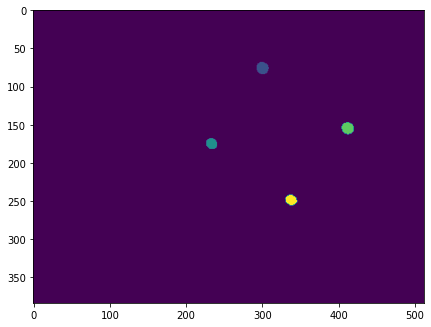

In [10]:
plt.figure(figsize=(7, 7))
plt.imshow(tf.argmax(y['output_1'], axis=3)[0], vmin=0, vmax=4)

# Tensorrt with trt_convert (8 bit)

In [2]:
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.compiler.tensorrt import trt_convert as trt

If memory growth is disabled tensorflow preallocates all GPU RAM and then I eventually run out of memory

In [3]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Must set up INT8 calibration

In [4]:
import sys
sys.path.append('../../')
from test_fast_inference.data import *

In [5]:
ds_raw = (
    tf.data.Dataset.list_files('../../batches/*.raw', shuffle=False)
    .map(preprocess_raw)
)

In [6]:
def calibration_input_fn():
    for x in ds_raw:
        yield (x, )

In [7]:
conversion_params = trt.DEFAULT_TRT_CONVERSION_PARAMS._replace(precision_mode=trt.TrtPrecisionMode.INT8,
                                                               max_workspace_size_bytes=2000000000)
converter = trt.TrtGraphConverterV2(input_saved_model_dir='model.tf', conversion_params=conversion_params)
converter.convert(calibration_input_fn=calibration_input_fn)
converter.save(output_saved_model_dir='model_8_trt.tf')

INFO:tensorflow:Linked TensorRT version: (7, 2, 0)
INFO:tensorflow:Loaded TensorRT version: (7, 2, 0)
INFO:tensorflow:Assets written to: model_8_trt.tf/assets


In [8]:
model = tf.saved_model.load('model_8_trt.tf', tags=[tag_constants.SERVING])
model = model.signatures['serving_default']

In [9]:
X = np.fromfile('../../batches/X0.raw', dtype=np.float32).reshape(1, 384, 512, 1)
X = tf.convert_to_tensor(X)

In [10]:
y = model(X)

In [11]:
%%timeit 
y = model(X)

2.41 ms ± 579 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [12]:
y['output_1'][0,0,0,0]

<tf.Tensor: shape=(), dtype=float32, numpy=3.7714844>

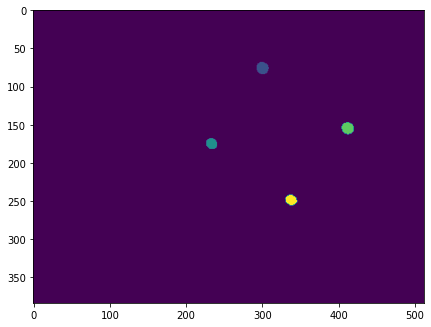

In [13]:
plt.figure(figsize=(7, 7))
plt.imshow(tf.argmax(y['output_1'], axis=3)[0], vmin=0, vmax=4)

# Compare

Again, INT8 seems to work but appears to be slower than FP16.